In [1]:
import ODElib #version 0.1.1, https://github.com/SEpapoulis/ODElib

import numpy as np
import pandas as pd
from scipy import integrate
from scipy import stats
%load_ext rpy2.ipython

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def BQAmp_ODE(y,t,ps):
    
    Rsr,Tsr,delta,mu1,c1,lam1,phi1,k1,e1,mu2,c2,lam2,phi2,k2,e2=ps
    R1,R2,T,C1,C2,H1,H2 = y
    
    
    dR1dt = Rsr - mu1*(1-c1)*(R1 / (k1+R1))*H1 - mu1*(R1 / (k1+R1))*C1
    dR2dt = Rsr - mu2*(1-c2)*(R2 / (k2+R2))*H2 - mu2*(R2 / (k2+R2))*C2
    
    dTdt = Tsr - (H1 / (lam1+H1) ) * T - (H2 / (lam2+H2) ) * T
    
    dH1dt = e1*mu1*(1-c1)*(R1 / (k1+R1))*H1 - delta*H1
    dH2dt = e2*mu2*(1-c2)*(R2 / (k2+R2))*H2 - delta*H2
    
    dC1dt = e1*mu1*(R1 / (k1+R1))*C1 - (T / (phi1+T))*C1 - delta*C1
    dC2dt = e2*mu2*(R2 / (k2+R2))*C2 - (T / (phi2+T))*C2 - delta*C2
    
    return (np.concatenate((dR1dt,dR2dt,dTdt,dC1dt,dC2dt,dH1dt,dH2dt), axis=None))

In [4]:
def BQToxinSimple_Analytical(Rsr,Tsr,delta,mu,c,lam,phi,k,e):
    R = -( k*delta / (delta-e*mu+c*e*mu))
    T = -(c*delta*phi) / (-1+c+c*delta)
    
    Hn = -(Tsr * lam * (-1+c+c*delta))
    Hd =  -Tsr+c*Tsr+c*Tsr*delta+c*delta*phi
    H = Hn/Hd
    
    Cn=(-1+c)*(-Rsr*Tsr*e+c*Rsr*Tsr*e+c*Rsr*Tsr*delta*e-Tsr*delta*lam+c*Tsr*delta*lam+c*Tsr*delta**2*lam+c*Rsr*delta*e*phi)
    Cd=(delta*(-Tsr+c*Tsr+c*Tsr*delta+c*delta*phi))
    C = -(Cn/Cd)
    return(np.array([R,T,C,H]))

def BQToxinSimple_Analytical_noC(Rsr,Tsr,delta,mu,c,lam,phi,k,e):
    R = -(k*delta / (delta-e*mu+c*e*mu))
    T = Tsr*(Rsr*e+delta*lam) / (Rsr*e)
    H = Rsr*e/delta
    C=0.0
    return(np.array([R,T,C,H]))

In [5]:
def sweep_pubpri(p,rng,equi=.5,phisamples=200,lamsamples=2000):
    parameters ={
        'mu':1,
        'c':.15,
        'k':10,
        'Rsr':5e7,
        'Tsr':1,
        'delta':0.1,
        'e':0.5,
        'lam':1e5,
        'phi':1
    }
    gl = {
        'mu':'µ',
        'phi' : 'ϕ',
        'lam' : 'λ',
        'e' : 'ε',
        'c':'c',
        'k':'k',
        'delta':'δ'
          }
    cols = ['R','T','cheater','helper','Rsr','Tsr','delta','mu','c','lam','phi','k','e']
    results = []
    labs = []
    for val in rng:
        lab = "{} = {}".format(gl[p],str(val))
        parameters[p]=val
        for phi in np.logspace(0,2,phisamples):
            results_phi = []
            parameters['phi']=phi
            for lam in np.logspace(5,10,lamsamples):
                parameters['lam']=lam
                try:
                    ana = BQToxinSimple_Analytical(**parameters)
                    if (ana > 0).all():
                        ps = np.array([parameters[p] for p in cols[4:]])
                        results_phi.append(np.concatenate([ana,ps]))
                    else:
                        ana = BQToxinSimple_Analytical_noC(**parameters)
                        ps = np.array([parameters[p] for p in cols[4:]])
                        results_phi.append(np.concatenate([ana,ps]))
                except ZeroDivisionError:
                        continue
            temp = np.array(results_phi)
            if len(temp):
            #temp[:,2]#cheaters
            #temp[:,3]#helpers
                if equi:
                    portionH = temp[:,3]/(temp[:,3]+temp[:,2])
                    eql = np.where(abs(equi-portionH) == min(abs(equi-portionH)))[0][0]
                    results.append(temp[eql])
                    labs.append(lab)
                else:
                    results.extend(temp)
                    labs.extend([lab]*len(temp))
        
    df = pd.DataFrame(results)
    df.columns=cols
    df["public_private"] = df['lam']/df['phi']
    df['helper_proportion'] = df['helper']/(df['cheater']+df['helper'])
    df['collab']=labs
    return(df)

In [6]:
df_e=sweep_pubpri('e',[0.2,0.5,0.75])
df_e = df_e[df_e['cheater']>0]

df_mu=sweep_pubpri('mu',[.5,1.0,1.5])
df_mu = df_mu[df_mu['cheater']>0]

df_c=sweep_pubpri('c',[.1,.15,.25])
df_c = df_c[df_c['cheater']>0]

df_k=sweep_pubpri('k',[1,10,1000])
df_k = df_k[df_k['cheater']>0]

df_d=sweep_pubpri('delta',[.10,.15,.2])
df_d = df_d[df_d['cheater']>0]


In [7]:
df_ref = sweep_pubpri('mu',[1.0],None,2000,200)[['cheater','helper','lam','phi','helper_proportion']]
df_ref5 = sweep_pubpri('mu',[1.0],0.5,2000,2000)[['cheater','helper','lam','phi','helper_proportion']]
df_ref5 = df_ref5[df_ref5['cheater']>0]


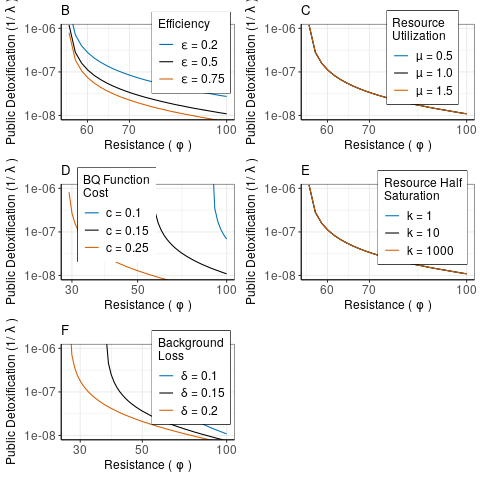

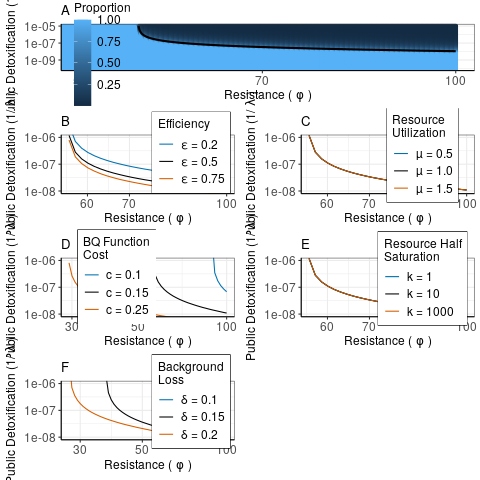

In [8]:
%%R -i df_e,df_mu,df_c,df_k,df_d,df_ref,df_ref5

library('ggplot2')
library('gridExtra')
axis_text_size=12

SimpleBQ_Landscape<-function(df_ref){
    xlab=expression("Resistance ("~ phi ~ ")")
    ylab=expression("Public Detoxification (1/"~lambda~")")
    landscape<-ggplot(df_ref,aes(x=phi,y=1/lam,color=helper_proportion))+
        geom_point()+
        labs(y=ylab,x=xlab,color="Helper\nProportion")+
        scale_y_log10()+
        scale_x_log10()+
        theme_bw()+
        theme(
            axis.line = element_line(colour = "black"), 
            legend.position=c(.10,.5),
            axis.text=element_text(size=axis_text_size),
            axis.title=element_text(size=axis_text_size),
            legend.text=element_text(size=axis_text_size),
            legend.title=element_text(size=axis_text_size),
            legend.background=element_blank(),
            strip.text=element_text(size=axis_text_size)
        )
    return(landscape)
}

space_plt <-function(df,lvls,greek_name){
    xlab=expression("Resistance ("~ phi ~ ")")
    ylab=expression("Public Detoxification (1/"~lambda~")")
    df$collab<-factor(df$collab,levels = lvls)
    meddf <- subset(df, collab==lvls[1])  
    plt <- ggplot(df,aes(x=phi,y=1/lam,color=collab))+
        geom_line()+
        scale_y_log10()+
        scale_x_log10()+
        theme_bw()+
        labs(y=ylab,x=xlab,color=greek_name)+
        theme(
            axis.line = element_line(colour = "black"),
            axis.text=element_text(size=axis_text_size),
            axis.title=element_text(size=axis_text_size),
            legend.text=element_text(size=axis_text_size),
            legend.title=element_text(size=axis_text_size),
            #legend.background=element_blank(),
            legend.box.background = element_rect(colour = "black"),
            strip.text=element_text(size=axis_text_size)
            )+
        scale_colour_manual(values=c("#0072B2","#000000", "#D55E00"))
    return(plt)
}
elvls=c('ε = 0.2', 'ε = 0.5' ,'ε = 0.75')
eplt<-space_plt(df_e,elvls,'Efficiency')+labs(title='B')+theme(legend.position=c(.75,.7))+
    coord_cartesian(ylim = c(1e-8, 1e-6))
mulvls=c('µ = 0.5', 'µ = 1.0', 'µ = 1.5')
muplt<-space_plt(df_mu,mulvls,'Resource\nUtilization')+labs(title='C')+theme(legend.position=c(.70,.65))+
    coord_cartesian(ylim = c(1e-8, 1e-6))
clvls=c('c = 0.1', 'c = 0.15', 'c = 0.25')
cplt<-space_plt(df_c,clvls,'BQ Function\nCost')+labs(title='D')+theme(legend.position=c(.32,.68))+
    coord_cartesian(ylim = c(1e-8, 1e-6))
klvls=c('k = 1','k = 10', 'k = 1000')
kplt<-space_plt(df_k,klvls,'Resource Half\nSaturation')+labs(title='E')+theme(legend.position=c(.70,.65))+
    coord_cartesian(ylim = c(1e-8, 1e-6))
dlvls=c('δ = 0.1','δ = 0.15', 'δ = 0.2')
dplt<-space_plt(df_d,dlvls,'Background\nLoss')+labs(title='F')+theme(legend.position=c(.75,.65))+
    coord_cartesian(ylim = c(1e-8, 1e-6))

ls<-SimpleBQ_Landscape(df_ref)+
    geom_line(data=df_ref5,mapping=aes(x=phi,y=1/lam),size=1,color='black')+labs(title='A')+
    coord_cartesian(xlim = c(50, 100))
plt<-grid.arrange(eplt,muplt,
                  cplt,kplt,dplt,
                  ncol=2
)
final<-grid.arrange(ls,plt,
                  ncol=1,heights=c(.3,1))

ggsave("figures/SimpleBQ.png",plot=final,width=8,height=12,device="png",dpi=300)

In [10]:
snames = ['Gal','Man','Amp',
          'GalCheat','ManCheat',
          'GalHelp','ManHelp']
pnames = ['Rsr','Tsr','delta',
          'mu1','c1','lam1','phi1','k1','e1',
          'mu2','c2','lam2','phi2','k2','e2']

mu=1
c=.15
lam=1e7 
phi=60
k=10
Rsr=5e7
Tsr=2
delta=0.1#5
e = 0.5
R,T,C,H=BQToxinSimple_Analytical(mu=mu,c=c,lam=lam,phi=phi,k=k,Rsr=Rsr,Tsr=Tsr/2,delta=delta,e=e)
cheater = C
helper = H
parameters = {'Rsr':Rsr,
                'Tsr':Tsr,
                'delta':delta,
                'Gal':R,
                'Man':R,
                'Amp':T,
                  #galactose parameters
                'mu1' : mu,
                'c1' : c,
                'lam1' : lam,
                'phi1' : phi,
                'k1' : k,
                'e1' : e,
                #mannose parameters
                'mu2' : mu,
                'c2' : c,
                'lam2' : lam,
                'phi2' : phi,
                'k2' : k,
                'e2' : e,
               #initial states based on analytical solution of simple mod
              'GalCheat':cheater,
              'ManCheat':cheater,
              'GalHelp':helper,
              'ManHelp':helper
}


BQ = ODElib.ModelFramework(BQAmp_ODE,t_steps=5000,t_end=1000,
                           parameter_names=pnames,
                           state_names=snames,
                           **parameters)


In [11]:
def process_equi(df,p1,p2,threshold=.005):
    _df=df[['GalCheat','ManCheat','GalHelp','ManHelp',p1,p2]]
    _df['total'] = _df[['GalCheat','ManCheat','GalHelp','ManHelp']].sum(axis=1)
    _df['proportion_helper'] = _df[['GalHelp','ManHelp']].sum(axis=1) / _df['total']
    _df['proportion_helperMan'] = _df['ManHelp'] / _df[['GalHelp','ManHelp']].sum(axis=1)    
    dfs = []
    for i in range(0,105,5):
        dfi=_df[_df['proportion_helperMan'].between(i/100 - threshold,i/100 + threshold)]
        dfi['proportion_helperMan']=i/100
        dfs.append(dfi)
    dfhelp = pd.concat(dfs)
    return(_df,dfhelp)

def Rprep(df,threshold=.001):
    dfs = []
    for i in range(0,105,10):
        dfi = df[df['proportion_helperMan'] > i/100-threshold]
        dfi = dfi[dfi['proportion_helperMan'] < i/100+threshold]
        dfi['bin_propman']= i/100
        dfs.append(dfi)
    return(pd.concat(dfs))

In [11]:
sample=10000
cores = 8

mudist = ODElib.parameter(stats.uniform,{'loc':.5,'scale':1.5})
df=BQ.explore_equilibriums(samples = sample,
                           cpu_cores=cores,
                           mu1=mudist,mu2=mudist)
mu,muhelp=process_equi(df,'mu1','mu2')

cdist = ODElib.parameter(stats.uniform,{'loc':.01,'scale':.2})
df=BQ.explore_equilibriums(samples = sample,
                           cpu_cores=cores,
                           c1=cdist,c2=cdist)
c,chelp=process_equi(df,'c1','c2')

phidist = ODElib.parameter(stats.uniform,{'loc':0,'scale':100})
df=BQ.explore_equilibriums(samples = sample,
                           cpu_cores=cores,
                           phi1=phidist,phi2=phidist)
phi,phihelp=process_equi(df,'phi1','phi2')

lamdist = ODElib.parameter(stats.loguniform,{'a':1e5,'b':1e10})
df=BQ.explore_equilibriums(samples = sample,
                           cpu_cores=cores,
                           lam1=lamdist,lam2=lamdist)
lam,lamhelp=process_equi(df,'lam1','lam2')

kdist = ODElib.parameter(stats.loguniform,{'a':1e0,'b':1e2})
df=BQ.explore_equilibriums(samples = sample,
                           cpu_cores=cores,
                           k1=kdist,k2=kdist)
k,khelp=process_equi(df,'k1','k2')


edist = ODElib.parameter(stats.uniform,{'loc':.2,'scale':.6})
df=BQ.explore_equilibriums(samples = sample,
                           cpu_cores=cores,
                           e1=edist,e2=edist)
e,ehelp=process_equi(df,'e1','e2')


Sampling with a Latin Hypercube scheme
Starting 8 processes with 8 cores	[DONE]
Sampling with a Latin Hypercube scheme
Starting 8 processes with 8 cores	[DONE]
Sampling with a Latin Hypercube scheme
Starting 8 processes with 8 cores	[DONE]
Sampling with a Latin Hypercube scheme
Starting 8 processes with 8 cores	[DONE]
Sampling with a Latin Hypercube scheme
Starting 8 processes with 8 cores	[DONE]
Sampling with a Latin Hypercube scheme
Starting 8 processes with 8 cores	[DONE]


In [12]:
mu_R = Rprep(mu)
c_R = Rprep(c)
phi_R = Rprep(phi)
lam_R = Rprep(lam)
k_R = Rprep(k)
e_R = Rprep(e)

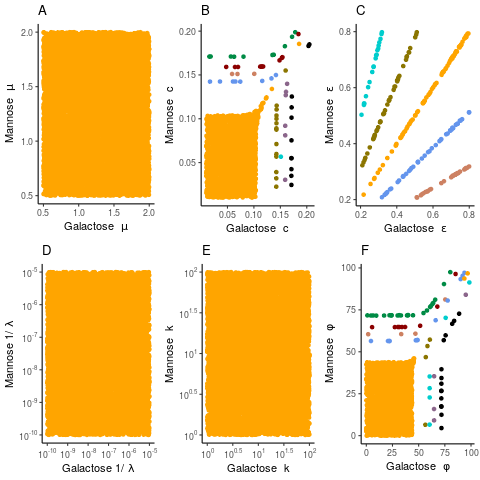

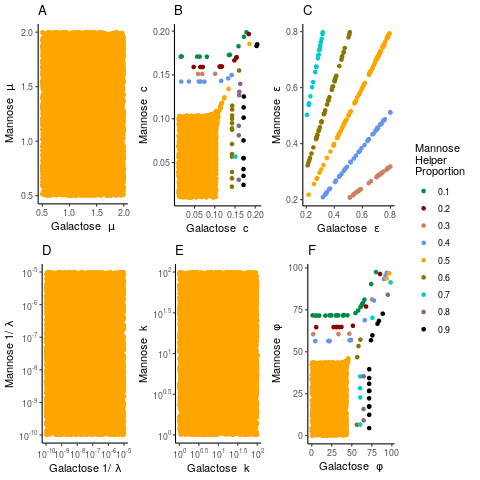

In [13]:
%%R -i mu_R,c_R,phi_R,lam_R,k_R,e_R
library('ggplot2')
library("gridExtra")
library('ggpubr')
custom_colorscale<-scale_colour_manual(values = c("0"   = "red",
                                                  "0.1" = "springgreen4",
                                                  "0.2" = "red4",
                                                  "0.3" = "lightsalmon3",
                                                  "0.4" = "cornflowerblue",
                                                  "0.5" = "orange1",
                                                  "0.6" = "gold4",
                                                  "0.7" = "cyan3",
                                                  "0.8" = "plum4",
                                                  "0.9" = "grey0",
                                                  "1.0" = "hotpink1"))
g_legend<-function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x){x$name}) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}
                      
fmt_landscape<-function(ggplt,xlab,ylab,scale_log10){
    plt<-ggplt+
    geom_point()+
    #geom_point(mapping=aes(color=proportion_helper))
    labs(x=xlab,y=ylab,color="Mannose\nHelper\nProportion")+
    theme_bw()+
    theme(panel.border = element_blank(),
      panel.grid.minor = element_blank(),
      panel.grid.major = element_blank(),
      axis.line = element_line(color="black"),
      #legend.position = "none"    
      )+custom_colorscale
    #scale_colour_gradient2(midpoint=0.5,limits=c(0,1))
    if (scale_log10){
        plt=plt+scale_x_log10(
                   breaks = scales::trans_breaks("log10", function(x) {10^x}),
                   #breaks = c(1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2),
                   labels = scales::trans_format("log10", scales::math_format(10^.x)))+
                scale_y_log10(
                   #breaks = c(1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2),
                   breaks = scales::trans_breaks("log10", function(x) {10^x}),
                   labels = scales::trans_format("log10", scales::math_format(10^.x)))
        }
    return(plt)
}

mu_gg = ggplot(mu_R,aes(x=mu1,y=mu2,color = as.factor(bin_propman),group = bin_propman))
c_gg = ggplot(c_R,aes(x=c1,y=c2,color = as.factor(bin_propman),group = bin_propman))
phi_gg = ggplot(phi_R,aes(x=phi1,y=phi2,color = as.factor(bin_propman),group = bin_propman))
lam_gg = ggplot(lam_R,aes(x=1/lam1,y=1/lam2,color = as.factor(bin_propman),group = bin_propman))
k_gg = ggplot(k_R,aes(x=k1,y=k2,color = as.factor(bin_propman),group = bin_propman))
e_gg = ggplot(e_R,aes(x=e1,y=e2,color = as.factor(bin_propman),group = bin_propman))

A=fmt_landscape(mu_gg,expression("Galactose " ~ mu),expression("Mannose " ~ mu),FALSE)
B=fmt_landscape(c_gg,expression("Galactose " ~ c),expression("Mannose " ~ c),FALSE)
C=fmt_landscape(phi_gg,expression("Galactose " ~ phi),expression("Mannose " ~ phi),FALSE)
D=fmt_landscape(lam_gg,expression("Galactose 1/" ~ lambda),expression("Mannose 1/" ~ lambda),TRUE)
E=fmt_landscape(k_gg,expression("Galactose " ~ k),expression("Mannose " ~ k),TRUE)
F=fmt_landscape(e_gg,expression("Galactose " ~ epsilon),expression("Mannose " ~ epsilon),FALSE)
l<-g_legend(B)
#ggplot_gtable(ggplot_build(A))

plt<-grid.arrange(A+theme(legend.position = "none")+labs(title='A'),B+theme(legend.position = "none")+labs(title='B'),
                  F+theme(legend.position = "none")+labs(title='C'),D+theme(legend.position = "none")+labs(title='D'),
                  E+theme(legend.position = "none")+labs(title='E'),C+theme(legend.position = "none")+labs(title='F'),
                  ncol=3
)
plt_l=grid.arrange(plt,l,ncol=2,widths=c(1,.20))
ggsave("figures/Landscape.png",plot=plt_l,width=8,height=6,device="png",dpi=300)


In [12]:
sample=100000
cores = 8

cdist = ODElib.parameter(stats.uniform,{'loc':.01,'scale':.2})
df=BQ.explore_equilibriums(samples = sample,
                           cpu_cores=cores,
                           c1=cdist,c2=cdist)
c,chelp=process_equi(df,'c1','c2')

phidist = ODElib.parameter(stats.uniform,{'loc':0,'scale':100})
df=BQ.explore_equilibriums(samples = sample,
                           cpu_cores=cores,
                           phi1=phidist,phi2=phidist)
phi,phihelp=process_equi(df,'phi1','phi2')

lamdist = ODElib.parameter(stats.loguniform,{'a':1e5,'b':1e10})
df=BQ.explore_equilibriums(samples = sample,
                           cpu_cores=cores,
                           lam1=lamdist,lam2=lamdist)
lam,lamhelp=process_equi(df,'lam1','lam2')

c_R = Rprep(c)
phi_R = Rprep(phi)
lam_R = Rprep(lam)


Sampling with a Latin Hypercube scheme
Starting 8 processes with 8 cores	[DONE]
Sampling with a Latin Hypercube scheme
Starting 8 processes with 8 cores	[DONE]
Sampling with a Latin Hypercube scheme
Starting 8 processes with 8 cores	[DONE]


In [13]:
sample=100000
cores = 8

lamdist = ODElib.parameter(stats.loguniform,{'a':1e5,'b':1e10})
phidist = ODElib.parameter(stats.uniform,{'loc':0,'scale':100})
df=BQ.explore_equilibriums(samples = sample,
                           cpu_cores=cores,
                           phi1=phidist, lam1=lamdist)
pl,plhelp=process_equi(df,'phi1','lam1')

Sampling with a Latin Hypercube scheme
Starting 8 processes with 8 cores	[DONE]


In [19]:
pl_R

,GalCheat,ManCheat,GalHelp,ManHelp,phi1,lam1,total,proportion_helper,proportion_helperMan,bin_propman
23,9.564536e-12,1.220306e+08,2.500000e+08,1.068601e+08,5.716556,5.980656e+06,4.788908e+08,0.745181,0.299445,0.3
222,1.962745e-11,1.218378e+08,2.500000e+08,1.070822e+08,5.745276,6.117241e+06,4.789200e+08,0.745599,0.299881,0.3
439,2.317067e-02,1.215408e+08,2.500000e+08,1.074327e+08,24.891463,6.139106e+06,4.789735e+08,0.746247,0.300568,0.3
760,1.438794e+02,1.218546e+08,2.499998e+08,1.070768e+08,31.979737,5.795834e+06,4.789313e+08,0.745569,0.299871,0.3
806,1.654361e-08,1.221687e+08,2.500000e+08,1.067055e+08,18.104494,5.786205e+06,4.788742e+08,0.744883,0.299142,0.3
...,...,...,...,...,...,...,...,...,...,...
9128,1.905106e+08,1.506829e+06,2.753514e+07,2.480879e+08,89.950121,5.353913e+07,4.676405e+08,0.589391,0.900099,0.9
10922,1.926834e+08,1.762083e+07,2.552141e+07,2.283603e+08,80.125027,2.297885e+07,4.641859e+08,0.546940,0.899475,0.9
11283,1.912293e+08,4.804700e+06,2.683040e+07,2.439913e+08,85.358589,3.767940e+07,4.668556e+08,0.580097,0.900930,0.9
11713,2.042248e+08,9.802641e+07,1.480644e+07,1.335737e+08,74.067614,3.281261e+06,4.506314e+08,0.329272,0.900213,0.9


In [14]:
pl_R = Rprep(pl)

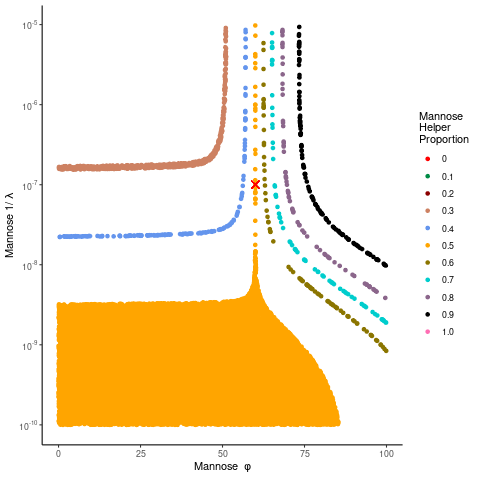

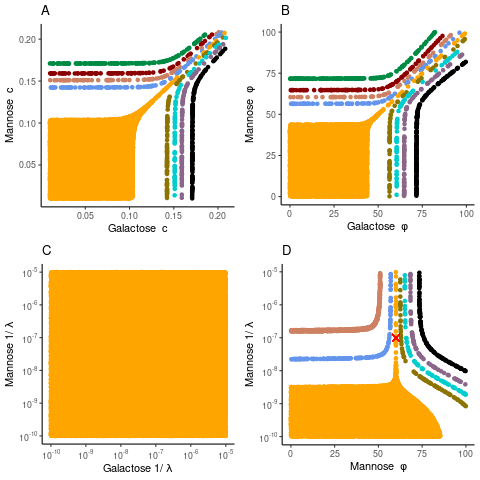

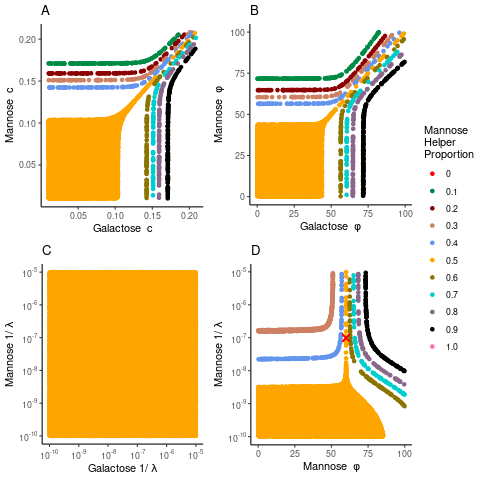

In [33]:
%%R -i c_R,phi_R,lam_R,pl_R
library('ggplot2')
library("gridExtra")
library('ggpubr')
custom_colorscale<-scale_colour_manual(values = c("0"   = "red",
                                                  "0.1" = "springgreen4",
                                                  "0.2" = "red4",
                                                  "0.3" = "lightsalmon3",
                                                  "0.4" = "cornflowerblue",
                                                  "0.5" = "orange1",
                                                  "0.6" = "gold4",
                                                  "0.7" = "cyan3",
                                                  "0.8" = "plum4",
                                                  "0.9" = "grey0",
                                                  "1.0" = "hotpink1"))
g_legend<-function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x){x$name}) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}
                      
fmt_landscape<-function(ggplt,xlab,ylab,scale_log10){
    plt<-ggplt+
    geom_point()+
    #geom_point(mapping=aes(color=proportion_helper))
    labs(x=xlab,y=ylab,color="Mannose\nHelper\nProportion")+
    theme_bw()+
    theme(panel.border = element_blank(),
      panel.grid.minor = element_blank(),
      panel.grid.major = element_blank(),
      axis.line = element_line(color="black"),
      #legend.position = "none"    
      )+custom_colorscale
    #scale_colour_gradient2(midpoint=0.5,limits=c(0,1))
    if (scale_log10){
        plt=plt+scale_x_log10(
                   breaks = scales::trans_breaks("log10", function(x) {10^x}),
                   #breaks = c(1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2),
                   labels = scales::trans_format("log10", scales::math_format(10^.x)))+
                scale_y_log10(
                   #breaks = c(1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2),
                   breaks = scales::trans_breaks("log10", function(x) {10^x}),
                   labels = scales::trans_format("log10", scales::math_format(10^.x)))
        }
    return(plt)
}

c_gg = ggplot(c_R,aes(x=c1,y=c2,color = as.factor(bin_propman),group = bin_propman))
phi_gg = ggplot(phi_R,aes(x=phi1,y=phi2,color = as.factor(bin_propman),group = bin_propman))
lam_gg = ggplot(lam_R,aes(x=1/lam1,y=1/lam2,color = as.factor(bin_propman),group = bin_propman))
pl_gg = ggplot(pl_R,aes(x=phi1,y=1/lam1,color = as.factor(bin_propman),group = bin_propman))


A=fmt_landscape(c_gg,expression("Galactose " ~ c),expression("Mannose " ~ c),FALSE)
B=fmt_landscape(phi_gg,expression("Galactose " ~ phi),expression("Mannose " ~ phi),FALSE)
C=fmt_landscape(lam_gg,expression("Galactose 1/" ~ lambda),expression("Mannose 1/" ~ lambda),TRUE)
D=fmt_landscape(pl_gg,expression("Mannose " ~ phi),expression("Mannose 1/" ~ lambda),FALSE)+
    scale_y_log10(
                   #breaks = c(1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2),
                   breaks = scales::trans_breaks("log10", function(x) {10^x}),
                   labels = scales::trans_format("log10", scales::math_format(10^.x)))+
    geom_point(mapping = aes(y = 1e-7, x = 60), shape = 4, size = 3, color = "red")

l<-g_legend(B)

print(D)
#ggplot_gtable(ggplot_build(A))

plt<-grid.arrange(A+theme(legend.position = "none")+labs(title='A'),
                  B+theme(legend.position = "none")+labs(title='B'),
                  C+theme(legend.position = "none")+labs(title='C'),
                  D+theme(legend.position = "none")+labs(title='D'),
                  ncol=2
)
plt <- grid.arrange(plt,l,ncol=2, widths = c(1,.15))

ggsave("figures/BQparameter_Landscape.png",plot=plt,width=8,height=6,device="png",dpi=300)


In [ ]:
lam=1e7 #leakiness
phi=60#essentiality 
